**Initial setup**

In [1]:
from google.colab import drive
import pandas as pd
import re
import copy
import pickle
import numpy as np
!pip install hazm
!pip install https://github.com/sobhe/hazm/archive/master.zip --upgrade
drive.mount('/content/drive')
data = pd.read_json('/content/drive/MyDrive/Information Retreival/data.json')



from __future__ import unicode_literals
from hazm import *
import nltk
from nltk.stem import PorterStemmer

stemmer = Stemmer()
normalizer = Normalizer()
lemmatizer = Lemmatizer()
tagger = POSTagger(model='/content/drive/MyDrive/Information Retreival/postagger.model')
chunker = Chunker(model='/content/drive/MyDrive/Information Retreival/chunker.model')
parser = DependencyParser(tagger=tagger, lemmatizer=lemmatizer)





  Using cached https://github.com/sobhe/hazm/archive/master.zip
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Prepare stopwords**

In [2]:
Array=[]
stopwords=[]

def prepareStopWords():
  #https://github.com/ziaa/Persian-stopwords-collection/blob/master/Stopwords/Kharazi/Pesian_Stop_Words_List.txt
  global stopwords
 
  
  with open('/content/drive/MyDrive/Information Retreival/stopwords.txt') as file:
    stopwords = [line.rstrip() for line in file]
 


  for i in range(len(stopwords)):
    stopwords[i]=stopwords[i].replace("\u200c", " ").split()



  for i in range(len(stopwords)):
    if i==len(stopwords):
      break


    if len(stopwords[i])==1:
      del stopwords[i]
 
  aux=[]
    # print(stopwords[i]) #list
  for i in range(len(stopwords)):
    for sub in stopwords[i]:
      aux.append(normalizer.normalize(sub))

  stopwords=copy.deepcopy(aux)

  

prepareStopWords()

  

**Preprocess documents**

In [3]:
def trimDocumentEnd():
  trim="انتهای پیام"

  global Array,stopwords
  Array=[]
  # print("data len",data.shape[1])
  # print("data len",data.shape[1])

  for i in range(data.shape[1]):

    idx=data[i]['content'].find(trim, 0, len(data[i]['content']))
    temp=data[i]['content']
    # print(type(word_tokenize(normalizer.normalize(temp))),len(word_tokenize(normalizer.normalize(temp))))

    # prevlen=len(Array)

    if idx==-1:
      Array.append(temp.replace("\u200c", " ").split())
    else:
      #  Array.append(temp[:idx])
       Array.append(temp[:idx].replace("\u200c", " ").split())
    


  auxArray=[]
  # print("Array len",len(Array))


  for i in range(len(Array)):
  # for i in range(1000):
    if i%(int(len(Array)/100))==0:
      print(i/int(len(Array)/100),"%")
    
    dummy=[]  
    for j in range(len(Array[i])):
      
      a = ':؟?،؛./\#*»«[]()_-!"《》'

      temp=copy.deepcopy(Array[i][j])

      for char in a:
        temp = temp.replace(char, "")

      
      temp=normalizer.normalize(temp)
      
    

      temp=stemmer.stem(temp)

    
      # if i==8:
      #   print("original : ",Array[i][j]," Stemmed : ",temp)
      isStopWord=False

    
      if not(temp in stopwords) and len(temp)>0:
        # if i==8:
        #   print("fate was to append\n")

        
        dummy.append(temp)

      # else:
      #   if i==8:
      #     print("fate was to remove\n")

    
    
    for g in range(len(dummy)-1):
      if dummy[g]=='انتهای' and dummy[g+1]=='پیام':
        del dummy[g]
        del dummy[g]

    auxArray.append(dummy)

   
  
  Array=copy.deepcopy(auxArray)


# trimDocumentEnd()

# np.save('/content/drive/MyDrive/Information Retreival/Array.npy',Array)
Array=np.load('/content/drive/MyDrive/Information Retreival/Array.npy',allow_pickle=True)



**Create posting list**

In [4]:
postingList={}


def createPostingsList():
  global postingList,Array

  # print(len(Array))
  # time.sleep(10)

  for docId in range(len(Array)):
  # for docId in range(10):


    for wordIndex in range(len(Array[docId])):

      word = Array[docId][wordIndex]
      # print(word,type(word))

      #word is not visited in postinglist yet
      if not (word in postingList):
        postingList[word]=[1,{str(docId):[1,[wordIndex]]}]
      
      #word already visited in postingslist
      else:
        #it is the first time this word is observed in the document i
        if not (str(docId) in postingList[word][1]):
          postingList[word][0]+=1
          postingList[word][1][str(docId)]=[1,[wordIndex]]
        
        #if the word is already observed in the document
        else:
      
          postingList[word][0]+=1
          postingList[word][1][str(docId)][0]+=1
          postingList[word][1][str(docId)][1].append(wordIndex)


# createPostingsList()


# np.save('/content/drive/MyDrive/Information Retreival/savedPL.npy', postingList) 
postingList = np.load('/content/drive/MyDrive/Information Retreival/savedPL.npy',allow_pickle='TRUE').item()





In [5]:
notQueries=[]
Queries=[]

def parseQuery(query):
  global Queries,notQueries
  i=0
  stillinQuery=False
  negate=False

  while(i<len(query)):
    if query[i]==" ":
      i+=1
      continue


    word=[]
    
    if query[i] != '"' and query[i] != "!":
      # print("normal")
      while query[i] != " ":
        # print("i=",i,query[i])
        word.append(query[i])
        i=i+1
        if i>= len(query):
          break

      i=i+1
      Queries.append(''.join(word))
      continue
    
    if query[i] == '"':
      i=i+1
      # print("quotation")


      while query[i] != '"':
        # print("i=",i,query[i])
        word.append(query[i])
        i=i+1

      i=i+1
      Queries.append(''.join(word))
      continue
    
    #After ! there is a space
    if query[i] == '!':
      # print("i=",i,query[i])
      i=i+1
      # print("not case")
      if query[i]==" ":
        # print("i=",i,query[i])
        i=i+1
      
      if query[i] != '"':
        while query[i] != " ":
          word.append(query[i])
          # print("i=",i,query[i])
          i=i+1

          if i>= len(query):
            break
        i=i+1

      else:
        i=i+1
        while query[i] != '"':
          word.append(query[i])
          # print("i=",i,query[i])
          i=i+1

          if i>= len(query):
            break

      i=i+1
      notQueries.append(''.join(word))
      continue

  aux=[]

  for q in range(len(notQueries)):
    word=normalizer.normalize(notQueries[q].strip())

    if not(word in stopwords) and len(word)>0:
       
        a = ':؟?،؛./\#*»«[]()_-!'
     
        for char in a:
          word = word.replace(char, "")
        
        print("1",word)
        word=normalizer.normalize(word)
        print("2",word)
        word=stemmer.stem(word)
        print("3",word)
        aux.append(word)
  

  notQueries=copy.deepcopy(aux)

  aux=[]

  for q in range(len(Queries)):
    word=normalizer.normalize(Queries[q].strip())

    if not(word in stopwords) and len(word)>0:
       
        a = ':؟?،؛./\#*»«[]()_-!'
     
        for char in a:
          word = word.replace(char, "")
        
        word=normalizer.normalize(word)
        word=stemmer.stem(word)
        aux.append(word)
  

  Queries=copy.deepcopy(aux)

  for q in range(len(Queries)):
    # print("prev Queries[q]",Queries[q])
    Queries[q]=Queries[q].replace("\u200c", " ").split()

  for q in range(len(notQueries)):
    # print("prev notQueries[q]",notQueries[q])
    notQueries[q]=notQueries[q].replace("\u200c", " ").split()  
  # for q in range(len(Queries)):
  #   Queries[q]=stemmer.stem(normalizer.normalize(Queries[q].strip()))  

  
  #    if not(temp in stopwords) and len(temp)>0:
  #       # if i==8:
  #       #   print("fate was to append\n")

        
  #       a = ':؟?،؛./\ # *»«[]()_-!'
     

  #       for char in a:
  #         temp = temp.replace(char, "")
        
  #       temp=normalizer.normalize(temp)
  #       temp=stemmer.stem(temp)
  



Query=input("Query")


# for i in range(len(Query)):
#   print(i," ",Query[i])


parseQuery(Query)

print("modified not Queries : ",notQueries)
print("modifed Queries : ",Queries)

found=0

def giveScore(word,docID,mode):
  docID=str(docID)
  global found

  if mode=="pos":
    if len(word)==1:
      if not (word[0] in postingList) or not(docID in postingList[word[0]][1]):
        return 0

      else: 
        # return postingList[word][1][docID][0]
        return postingList[word[0]][1][docID][0]
      
   

    else:
      found = 0
      return backTrack(word,0,docID,0)
      

  elif mode=="neg":
    if len(word)==1:
      if not(word[0] in postingList):
        return 1
        
      if docID in postingList[word[0]][1]:
        # return postingList[word][1][docID][0]
        return -postingList[word[0]][1][docID][0]
      
      else:
        return 1

    else:
      found = 0
      temp=backTrack(word,0,docID,0)

      if temp>0:
        return -temp*2
      
      else:
        return 1
      

  else:
    raise Exception("Not a valid mode!")


def backTrack(wordArray,depth,docID,expectedIDX):
  docID=str(docID)
  global found



  if depth==0:

    if not(wordArray[0] in postingList):
      return 0

    if docID in postingList[wordArray[0]][1]:

      for occuredFirstPosition in postingList[wordArray[0]][1][docID][1]:
        backTrack(wordArray,depth+1,docID,occuredFirstPosition+1)
    
    return found
      
  elif depth<len(wordArray):
    if not (wordArray[depth] in postingList):
      return 

    if docID in postingList[wordArray[depth]][1] and (expectedIDX in postingList[wordArray[depth]][1][docID][1]):
      backTrack(wordArray,depth+1,docID,expectedIDX+1)
    
  
  elif depth==len(wordArray):
    found=found+1


def scoreWrapper(docID):
  docID=str(docID)

  score=np.zeros((len(Queries)+len(notQueries,)))
  
  for i in range(len(Queries)):
    score[i]= giveScore(Queries[i],docID,'pos')
  
  for i in range(len(notQueries)):
    score[i+len(Queries)]= giveScore(notQueries[i],docID,'neg')
  
  # print(score)

  fullSatisfaction=1

  for i in range(score.shape[0]):
    if score[i]<1:
      fullSatisfaction=0
      break
  
  docScore=0
  null=True

  for i in range(len(Queries)):
    if score[i]>0:
      null=False
      break

  if null:
    fullSatisfaction=-1

  if fullSatisfaction==1:
    docScore=np.amin(score)*score.shape[0]
    score=score-np.amin(score)
    docScore+=np.mean(score)

  elif fullSatisfaction==0:
    docScore=np.mean(score)

  else:
    docScore=-100
  
  return(fullSatisfaction,docScore)


class QueryResponse:
  def __init__(self,docID,satisfation,score):
    self.docID = docID
    self.satisfaction = satisfation
    self.score=score
  
  def __lt__(self,other):
    if self.satisfaction > other.satisfaction:
      return False

    elif self.satisfaction< other.satisfaction:
      return True

    elif self.satisfaction == other.satisfaction:
      return self.score<other.score

def retrieve():
    result=[]

    for docID in range(len(Array)):
      temp=scoreWrapper(docID)

      if temp[0]== -1:
        continue

      docFate=QueryResponse(docID,temp[0],temp[1])

      result.append(copy.deepcopy(docFate))
      result.sort()

      if len(result)==6:
        del result[0]

    return result

result=retrieve()
result.reverse()

# print(type(result))
print(len(result)," result(s) found")

for r in result:
  docID=r.docID
  print("docID=",docID," url=",data[docID]['url']," document score=",np.round(r.score,3))

# temp=0

#for key in postingList:
 # print(key,)
 # temp=temp+1


Queryگوجه ! صادرات
1 صادرات
2 صادرات
3 صادر
modified not Queries :  [['صادر']]
modifed Queries :  [['گوجه']]
3  result(s) found
docID= 10278  url= https://www.farsnews.ir/news/14000912000414/ماجرای-هماهنگی-با-حاکم-بلوچستان-پاکستان-برای-آزادی-گروگان‌‌های-گروهک  document score= 2.0
docID= 12005  url= https://www.farsnews.ir/news/14000728000454/کرمی-به-بعضی-از-همسایگان-ایران-تذکر-می-دهم-که-حرمت-بزرگ‌تر-از-خود-را  document score= 0.0
docID= 9988  url= https://www.farsnews.ir/news/14000919000346/جلیلی-اتکاءبه-تولیدات-روستایی-می‌تواند-موجب-رشد-ارزآوری-در-کشور-شود  document score= -1.0


In [29]:
print(data[7546]['content'])
for i in(postingList['تورم'][1]['7546'][1]):
  print(i)

scoreWrapper(7546)
print(stemmer.stem('تورم'))


جبار کوچکی‌نژاد رئیس هیات تحقیق و تفحص مجلس از نحوه هزینه‌کرد ارز ترجیحی، در گفت‌وگو با خبرنگار پارلمانی خبرگزاری فارس، با اشاره به جلسه غیرعلنی صبح امروز مجلس و رایزنی دولت برای بازگشت مجلس به لایحه دولت و حذف ارز ترجیحی، اظهار داشت: معتقدیم با مصوبه کمیسیون تلفیق که 9 میلیارد دلار ارز ترجیحی برای سال آینده اختصاص داده، تکلیف کار معلوم نیست و دولت هم نمی‌تواند با این میزان ارز به خوبی برنامه‌ریزی کند. وی افزود: دولت 18 میلیارد دلار ارز ترجیحی نیاز دارد که 13.5 میلیارد دلار از آن برای نهاده‌های دامی و کشاورزی و بقیه‌ آن برای دارو و تجهیزات پزشکی صرف می‌شود، لذا با این رقم 9 میلیارد دلار عملا تکلیف مدیریت این بخش معلوم نیست، لذا مجلس باید تصمیم روشن و دقیقی بگیرد. عضو کمیسیون برنامه و بودجه مجلس تصریح کرد: می‌توان در خصوص ارز ترجیحی به لایحه دولت بازگشت، اما دولت هم در این زمینه حرف هماهنگ و یکسانی نمی‌زند که مثلا راه‌های جبران حذف ارز ترجیحی چیست و با چه سازوکاری می‌خواهند از دهک‌های مختلف حمایت کنند، به همین خاطر مجلس با نگرانی کار را‌‌‌‌‌‌‌‌ دنبال می‌کند. کوچکی‌نژاد تأکید کرد: به نظ

In [13]:
stemmer.stem('تورمی')

'تورم'

**Zipf law stopwords removed**

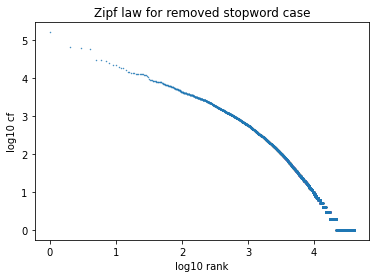

In [ ]:
import matplotlib.pyplot as plt

class Token:
  def __init__(self,word,cf):
    self.word=word
    self.cf=cf

  def __lt__(self,other):
    return self.cf<other.cf


tokenStats=[]

def constructTokenStatistics():
  
  for key in postingList:
    tokenStats.append(Token(key,postingList[key][0]))

  tokenStats.sort()
  tokenStats.reverse()

  x=[]
  y=[]

  for i in range(len(tokenStats)):
    x.append(np.log10(i+1))
    y.append(np.log10(tokenStats[i].cf))

  plt.scatter(x, y,s=0.2)
  plt.title("Zipf law for removed stopword case")
  plt.xlabel("log10 rank")
  plt.ylabel("log10 cf")
  plt.show()

constructTokenStatistics()



**Zipf law stopwords not removed**

In [ ]:
stopwords=[]
Array=[]
postingList={}


def trimDocumentEnd():
  trim="انتهای پیام"

  global Array,stopwords
  Array=[]
  # print("data len",data.shape[1])
  # print("data len",data.shape[1])

  for i in range(data.shape[1]):

    idx=data[i]['content'].find(trim, 0, len(data[i]['content']))
    temp=data[i]['content']
    # print(type(word_tokenize(normalizer.normalize(temp))),len(word_tokenize(normalizer.normalize(temp))))

    # prevlen=len(Array)

    if idx==-1:
      Array.append(temp.replace("\u200c", " ").split())
    else:
      #  Array.append(temp[:idx])
       Array.append(temp[:idx].replace("\u200c", " ").split())
    


  auxArray=[]
  # print("Array len",len(Array))


  for i in range(len(Array)):
  # for i in range(1000):
    if i%(int(len(Array)/100))==0:
      print(i/int(len(Array)/100),"%")
    
    dummy=[]  
    for j in range(len(Array[i])):
      
      a = ':؟?،؛./\#*»«[]()_-!"《》'

      temp=copy.deepcopy(Array[i][j])

      for char in a:
        temp = temp.replace(char, "")

      
      temp=normalizer.normalize(temp)
      temp=stemmer.stem(temp)
      # if i==8:
      #   print("original : ",Array[i][j]," Stemmed : ",temp)
      isStopWord=False

    
      if not(temp in stopwords) and len(temp)>0:
        # if i==8:
        #   print("fate was to append\n")

        
        dummy.append(temp)

      # else:
      #   if i==8:
      #     print("fate was to remove\n")

    
    
    for g in range(len(dummy)-1):
      if dummy[g]=='انتهای' and dummy[g+1]=='پیام':
        del dummy[g]
        del dummy[g]

    auxArray.append(dummy)

   
  
  Array=copy.deepcopy(auxArray)


def createPostingsList():
  global postingList,Array

  # print(len(Array))
  # time.sleep(10)

  for docId in range(len(Array)):
  # for docId in range(10):


    for wordIndex in range(len(Array[docId])):

      word = Array[docId][wordIndex]
      # print(word,type(word))

      #word is not visited in postinglist yet
      if not (word in postingList):
        postingList[word]=[1,{str(docId):[1,[wordIndex]]}]
      
      #word already visited in postingslist
      else:
        #it is the first time this word is observed in the document i
        if not (str(docId) in postingList[word][1]):
          postingList[word][0]+=1
          postingList[word][1][str(docId)]=[1,[wordIndex]]
        
        #if the word is already observed in the document
        else:
      
          postingList[word][0]+=1
          postingList[word][1][str(docId)][0]+=1
          postingList[word][1][str(docId)][1].append(wordIndex)





# np.save('/content/drive/MyDrive/Information Retreival/savedPL.npy', postingList) 
# postingList = np.load('/content/drive/MyDrive/Information Retreival/savedPL.npy',allow_pickle='TRUE').item()


trimDocumentEnd()
createPostingsList()

# np.save('/content/drive/MyDrive/Information Retreival/SWArray.npy',Array)
# Array=np.load('/content/drive/MyDrive/Information Retreival/Array.npy',allow_pickle=True)



0.0 %
1.0 %
2.0 %
3.0 %
4.0 %
5.0 %
6.0 %
7.0 %
8.0 %
9.0 %
10.0 %
11.0 %
12.0 %
13.0 %
14.0 %
15.0 %
16.0 %
17.0 %
18.0 %
19.0 %
20.0 %
21.0 %
22.0 %
23.0 %
24.0 %
25.0 %
26.0 %
27.0 %
28.0 %
29.0 %
30.0 %
31.0 %
32.0 %
33.0 %
34.0 %
35.0 %
36.0 %
37.0 %
38.0 %
39.0 %
40.0 %
41.0 %
42.0 %
43.0 %
44.0 %
45.0 %
46.0 %
47.0 %
48.0 %
49.0 %
50.0 %
51.0 %
52.0 %
53.0 %
54.0 %
55.0 %
56.0 %
57.0 %
58.0 %
59.0 %
60.0 %
61.0 %
62.0 %
63.0 %
64.0 %
65.0 %
66.0 %
67.0 %
68.0 %
69.0 %
70.0 %
71.0 %
72.0 %
73.0 %
74.0 %
75.0 %
76.0 %
77.0 %
78.0 %
79.0 %
80.0 %
81.0 %
82.0 %
83.0 %
84.0 %
85.0 %
86.0 %
87.0 %
88.0 %
89.0 %
90.0 %
91.0 %
92.0 %
93.0 %
94.0 %
95.0 %
96.0 %
97.0 %
98.0 %
99.0 %
100.0 %


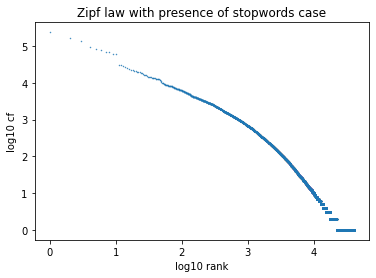

In [ ]:
import matplotlib.pyplot as plt

class Token:
  def __init__(self,word,cf):
    self.word=word
    self.cf=cf

  def __lt__(self,other):
    return self.cf<other.cf


tokenStats=[]

def constructTokenStatistics():
  
  for key in postingList:
    tokenStats.append(Token(key,postingList[key][0]))

  tokenStats.sort()
  tokenStats.reverse()

  x=[]
  y=[]

  for i in range(len(tokenStats)):
    x.append(np.log10(i+1))
    y.append(np.log10(tokenStats[i].cf))

  plt.scatter(x, y,s=0.2)
  plt.title("Zipf law with presence of stopwords case")
  plt.xlabel("log10 rank")
  plt.ylabel("log10 cf")
  plt.show()

constructTokenStatistics()

**Heap law with stemming**



In [ ]:
Array=[]
stopwords=[]

def prepareStopWords():
  #https://github.com/ziaa/Persian-stopwords-collection/blob/master/Stopwords/Kharazi/Pesian_Stop_Words_List.txt
  global stopwords
 
  
  with open('/content/drive/MyDrive/Information Retreival/stopwords.txt') as file:
    stopwords = [line.rstrip() for line in file]
 


  for i in range(len(stopwords)):
    stopwords[i]=stopwords[i].replace("\u200c", " ").split()



  for i in range(len(stopwords)):
    if i==len(stopwords):
      break


    if len(stopwords[i])==1:
      del stopwords[i]
 
  aux=[]
    # print(stopwords[i]) #list
  for i in range(len(stopwords)):
    for sub in stopwords[i]:
      aux.append(normalizer.normalize(sub))

  stopwords=copy.deepcopy(aux)

  

prepareStopWords()


In [ ]:
def trimDocumentEnd(numberOfDocs):
  trim="انتهای پیام"
  discoveredWords={}
  total=0

  global Array,stopwords
  Array=[]
  # print("data len",data.shape[1])
  # print("data len",data.shape[1])

  for i in range(numberOfDocs):

    idx=data[i]['content'].find(trim, 0, len(data[i]['content']))
    temp=data[i]['content']
    # print(type(word_tokenize(normalizer.normalize(temp))),len(word_tokenize(normalizer.normalize(temp))))

    # prevlen=len(Array)

    if idx==-1:
      Array.append(temp.replace("\u200c", " ").split())
    else:
      #  Array.append(temp[:idx])
       Array.append(temp[:idx].replace("\u200c", " ").split())
    


  auxArray=[]
  # print("Array len",len(Array))


  for i in range(len(Array)):
  # for i in range(1000):
    # if i%(int(len(Array)/100))==0:
    #   print(i/int(len(Array)/100),"%")
    
    dummy=[]  
    for j in range(len(Array[i])):
      
      a = ':؟?،؛./\#*»«[]()_-!"《》'

      temp=copy.deepcopy(Array[i][j])

      for char in a:
        temp = temp.replace(char, "")

      
      temp=normalizer.normalize(temp)
      temp=stemmer.stem(temp)
      # if i==8:
      #   print("original : ",Array[i][j]," Stemmed : ",temp)
      isStopWord=False

    
      if not(temp in stopwords) and len(temp)>0:
        # if i==8:
        #   print("fate was to append\n")

   
        dummy.append(temp)

      # else:
      #   if i==8:
      #     print("fate was to remove\n")

    
    
    for g in range(len(dummy)-1):
      if dummy[g]=='انتهای' and dummy[g+1]=='پیام':
        del dummy[g]
        del dummy[g]
    
    for temp in dummy:
      if not(temp in discoveredWords):
        discoveredWords[temp]=0
        total+=1


    auxArray.append(dummy)

   
  
  return total


numbers=[500,1000,1500,2000]
x=[]
y=[]

for number in numbers:
  res=trimDocumentEnd(number)
  print("number of docs = ",number," vocabulary size= ",res)
  x.append(np.log10(number))
  y.append(np.log10(res))
  


# np.save('/content/drive/MyDrive/Information Retreival/Array.npy',Array)
# Array=np.load('/content/drive/MyDrive/Information Retreival/Array.npy',allow_pickle=True)



number of docs =  500  vocabulary size=  6678
number of docs =  1000  vocabulary size=  9494
number of docs =  1500  vocabulary size=  11281
number of docs =  2000  vocabulary size=  12790


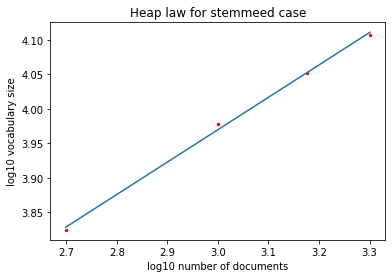

slope is  0.4688590293584949
intercept is  2.5631108641756777
correlation coefficient is  0.9989879395733552
regression's p value is  0.0010120604266448117
expected dictionary size for full document set is  30134.98267074677
real dictionary size for full document set is  40405


In [ ]:
postingList = np.load('/content/drive/MyDrive/Information Retreival/savedPL.npy',allow_pickle='TRUE').item()
print()
plt.scatter(x, y,s=6,color='red')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.title("Heap law for stemmeed case")
plt.xlabel("log10 number of documents")
plt.ylabel("log10 vocabulary size")
plt.show()

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

print("slope is ",slope)
print("intercept is ",intercept)
print("correlation coefficient is ",r_value)
print("regression's p value is ",p_value)
print("expected dictionary size for full document set is ",10**(slope*np.log10(data.shape[1])+intercept))
print("real dictionary size for full document set is ",len(postingList))





In [ ]:
def trimDocumentEnd():
  Array=np.load('/content/drive/MyDrive/Information Retreival/Array.npy',allow_pickle=True)

  trim="انتهای پیام"
  discoveredWords={}
  total=0

  global stopwords
  Array=[]
  # print("data len",data.shape[1])
  # print("data len",data.shape[1])

  for i in range(data.shape[1]):

    idx=data[i]['content'].find(trim, 0, len(data[i]['content']))
    temp=data[i]['content']
    # print(type(word_tokenize(normalizer.normalize(temp))),len(word_tokenize(normalizer.normalize(temp))))

    # prevlen=len(Array)

    if idx==-1:
      Array.append(temp.replace("\u200c", " ").split())
    else:
      #  Array.append(temp[:idx])
       Array.append(temp[:idx].replace("\u200c", " ").split())
    


  auxArray=[]
  # print("Array len",len(Array))


  for i in range(len(Array)):
  # for i in range(1000):
    if i%(int(len(Array)/100))==0:
      print(i/int(len(Array)/100),"%")
    
    dummy=[]  
    for j in range(len(Array[i])):
      
      a = ':؟?،؛./\#*»«[]()_-!"《》'

      temp=copy.deepcopy(Array[i][j])

      for char in a:
        temp = temp.replace(char, "")

      
      temp=normalizer.normalize(temp)
      temp=stemmer.stem(temp)
      # if i==8:
      #   print("original : ",Array[i][j]," Stemmed : ",temp)
      isStopWord=False

    
      if not(temp in stopwords) and len(temp)>0:
        # if i==8:
        #   print("fate was to append\n")

   
        dummy.append(temp)

      # else:
      #   if i==8:
      #     print("fate was to remove\n")

    
    
    for g in range(len(dummy)-1):
      if dummy[g]=='انتهای' and dummy[g+1]=='پیام':
        del dummy[g]
        del dummy[g]
    
    for temp in dummy:
      if not(temp in discoveredWords):
        discoveredWords[temp]=0
        total+=1

    
    
    y.append(np.log10(total))
    x.append(np.log10(i+1))


   
  

x=[]
y=[]

trimDocumentEnd()

  


0.0 %
1.0 %
2.0 %
3.0 %
4.0 %
5.0 %
6.0 %
7.0 %
8.0 %
9.0 %
10.0 %
11.0 %
12.0 %
13.0 %
14.0 %
15.0 %
16.0 %
17.0 %
18.0 %
19.0 %
20.0 %
21.0 %
22.0 %
23.0 %
24.0 %
25.0 %
26.0 %
27.0 %
28.0 %
29.0 %
30.0 %
31.0 %
32.0 %
33.0 %
34.0 %
35.0 %
36.0 %
37.0 %
38.0 %
39.0 %
40.0 %
41.0 %
42.0 %
43.0 %
44.0 %
45.0 %
46.0 %
47.0 %
48.0 %
49.0 %
50.0 %
51.0 %
52.0 %
53.0 %
54.0 %
55.0 %
56.0 %
57.0 %
58.0 %
59.0 %
60.0 %
61.0 %
62.0 %
63.0 %
64.0 %
65.0 %
66.0 %
67.0 %
68.0 %
69.0 %
70.0 %
71.0 %
72.0 %
73.0 %
74.0 %
75.0 %
76.0 %
77.0 %
78.0 %
79.0 %
80.0 %
81.0 %
82.0 %
83.0 %
84.0 %
85.0 %
86.0 %
87.0 %
88.0 %
89.0 %
90.0 %
91.0 %
92.0 %
93.0 %
94.0 %
95.0 %
96.0 %
97.0 %
98.0 %
99.0 %
100.0 %


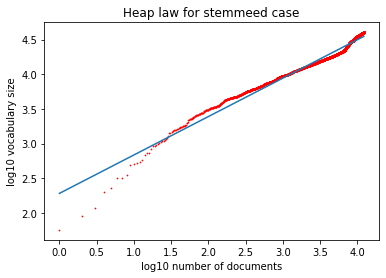

slope is  0.553981695117825
intercept is  2.282723319097574
correlation coefficient is  0.9826756928532686
regression's p value is  0.0
expected dictionary size for full document set is  35199.07922611
real dictionary size for full document set is  40405
12202
12202


In [ ]:

postingList = np.load('/content/drive/MyDrive/Information Retreival/savedPL.npy',allow_pickle='TRUE').item()
print()
plt.scatter(x, y,s=0.5,color='red')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.title("Heap law for stemmeed case")
plt.xlabel("log10 number of documents")
plt.ylabel("log10 vocabulary size")
plt.show()

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

print("slope is ",slope)
print("intercept is ",intercept)
print("correlation coefficient is ",r_value)
print("regression's p value is ",p_value)
print("expected dictionary size for full document set is ",10**(slope*np.log10(data.shape[1])+intercept))
print("real dictionary size for full document set is ",len(postingList))

print(len(x))
print(len(y))


**Heap law without stemming**

In [ ]:
stopwords=[]

def prepareStopWords():
  #https://github.com/ziaa/Persian-stopwords-collection/blob/master/Stopwords/Kharazi/Pesian_Stop_Words_List.txt
  global stopwords
 
  
  with open('/content/drive/MyDrive/Information Retreival/stopwords.txt') as file:
    stopwords = [line.rstrip() for line in file]
 


  for i in range(len(stopwords)):
    stopwords[i]=stopwords[i].replace("\u200c", " ").split()



  for i in range(len(stopwords)):
    if i==len(stopwords):
      break


    if len(stopwords[i])==1:
      del stopwords[i]
 
  aux=[]
    # print(stopwords[i]) #list
  for i in range(len(stopwords)):
    for sub in stopwords[i]:
      aux.append(normalizer.normalize(sub))

  stopwords=copy.deepcopy(aux)

  

prepareStopWords()


In [ ]:
def trimDocumentEnd(numberOfDocs):
  trim="انتهای پیام"
  discoveredWords={}
  total=0

  global Array,stopwords
  Array=[]
  # print("data len",data.shape[1])
  # print("data len",data.shape[1])

  for i in range(numberOfDocs):

    idx=data[i]['content'].find(trim, 0, len(data[i]['content']))
    temp=data[i]['content']
    # print(type(word_tokenize(normalizer.normalize(temp))),len(word_tokenize(normalizer.normalize(temp))))

    # prevlen=len(Array)

    if idx==-1:
      Array.append(temp.replace("\u200c", " ").split())
    else:
      #  Array.append(temp[:idx])
       Array.append(temp[:idx].replace("\u200c", " ").split())
    


  auxArray=[]
  # print("Array len",len(Array))


  for i in range(len(Array)):
  # for i in range(1000):
    # if i%(int(len(Array)/100))==0:
    #   print(i/int(len(Array)/100),"%")
    
    dummy=[]  
    for j in range(len(Array[i])):
      
      a = ':؟?،؛./\#*»«[]()_-!"《》'

      temp=copy.deepcopy(Array[i][j])

      for char in a:
        temp = temp.replace(char, "")

      
      temp=normalizer.normalize(temp)
      # temp=stemmer.stem(temp)
      # if i==8:
      #   print("original : ",Array[i][j]," Stemmed : ",temp)
      isStopWord=False

    
      if not(temp in stopwords) and len(temp)>0:
        # if i==8:
        #   print("fate was to append\n")

   
        dummy.append(temp)

      # else:
      #   if i==8:
      #     print("fate was to remove\n")

    
    
    if len(dummy)>1:
      if dummy[-1]=='انتهای' and dummy[-2]=='پیام':
          
          del dummy[-1]
          del dummy[-1]
    
    for temp in dummy:
      if not(temp in discoveredWords):
        discoveredWords[temp]=0
        total+=1


    auxArray.append(dummy)

   
  
  return total


numbers=[500,1000,1500,2000]
x=[]
y=[]

for number in numbers:
  res=trimDocumentEnd(number)
  print("number of docs = ",number," vocabulary size= ",res)
  x.append(np.log10(number))
  y.append(np.log10(res))
  
print("for all docs = ",data.shape[1]," vocabulary size= ",trimDocumentEnd(data.shape[1]))

# np.save('/content/drive/MyDrive/Information Retreival/Array.npy',Array)
# Array=np.load('/content/drive/MyDrive/Information Retreival/Array.npy',allow_pickle=True)

number of docs =  500  vocabulary size=  8507
number of docs =  1000  vocabulary size=  12310
number of docs =  1500  vocabulary size=  14722
number of docs =  2000  vocabulary size=  16714
for all docs =  12202  vocabulary size=  53791


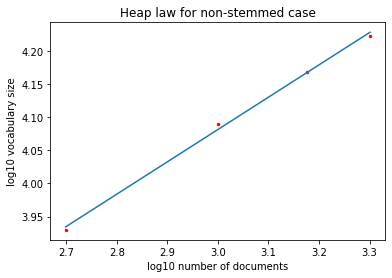

slope is  0.48790527138857975
intercept is  2.6175756466903297
correlation coefficient is  0.9986840596861749
regression's p value is  0.0013159403138250923
expected dictionary size for full document set is  40866.447169313826
real dictionary size for full document set is  40405


In [ ]:
postingList = np.load('/content/drive/MyDrive/Information Retreival/savedPL.npy',allow_pickle='TRUE').item()
print()
plt.scatter(x, y,s=6,color='red')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.title("Heap law for non-stemmed case")
plt.xlabel("log10 number of documents")
plt.ylabel("log10 vocabulary size")
plt.show()

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

print("slope is ",slope)
print("intercept is ",intercept)
print("correlation coefficient is ",r_value)
print("regression's p value is ",p_value)
print("expected dictionary size for full document set is ",10**(slope*np.log10(data.shape[1])+intercept))
print("real dictionary size for full document set is ",len(postingList))





In [ ]:
def trimDocumentEnd():
  Array=np.load('/content/drive/MyDrive/Information Retreival/Array.npy',allow_pickle=True)

  trim="انتهای پیام"
  discoveredWords={}
  total=0

  global stopwords
  Array=[]
  # print("data len",data.shape[1])
  # print("data len",data.shape[1])

  for i in range(data.shape[1]):

    idx=data[i]['content'].find(trim, 0, len(data[i]['content']))
    temp=data[i]['content']
    # print(type(word_tokenize(normalizer.normalize(temp))),len(word_tokenize(normalizer.normalize(temp))))

    # prevlen=len(Array)

    if idx==-1:
      Array.append(temp.replace("\u200c", " ").split())
    else:
      #  Array.append(temp[:idx])
       Array.append(temp[:idx].replace("\u200c", " ").split())
    


  auxArray=[]
  # print("Array len",len(Array))


  for i in range(len(Array)):
  # for i in range(1000):
    if i%(int(len(Array)/100))==0:
      print(i/int(len(Array)/100),"%")
    
    dummy=[]  
    for j in range(len(Array[i])):
      
      a = ':؟?،؛./\#*»«[]()_-!"《》'

      temp=copy.deepcopy(Array[i][j])

      for char in a:
        temp = temp.replace(char, "")

      
      temp=normalizer.normalize(temp)
      # temp=stemmer.stem(temp)
      # if i==8:
      #   print("original : ",Array[i][j]," Stemmed : ",temp)
      isStopWord=False

    
      if not(temp in stopwords) and len(temp)>0:
        # if i==8:
        #   print("fate was to append\n")

   
        dummy.append(temp)

      # else:
      #   if i==8:
      #     print("fate was to remove\n")

    
    
    if len(dummy)>1:
      if dummy[-1]=='انتهای' and dummy[-2]=='پیام':
          
          del dummy[-1]
          del dummy[-1]
    
    for temp in dummy:
      if not(temp in discoveredWords):
        discoveredWords[temp]=0
        total+=1

    
    
    y.append(np.log10(total))
    x.append(np.log10(i+1))


   
  

x=[]
y=[]

trimDocumentEnd()

  


0.0 %
1.0 %
2.0 %
3.0 %
4.0 %
5.0 %
6.0 %
7.0 %
8.0 %
9.0 %
10.0 %
11.0 %
12.0 %
13.0 %
14.0 %
15.0 %
16.0 %
17.0 %
18.0 %
19.0 %
20.0 %
21.0 %
22.0 %
23.0 %
24.0 %
25.0 %
26.0 %
27.0 %
28.0 %
29.0 %
30.0 %
31.0 %
32.0 %
33.0 %
34.0 %
35.0 %
36.0 %
37.0 %
38.0 %
39.0 %
40.0 %
41.0 %
42.0 %
43.0 %
44.0 %
45.0 %
46.0 %
47.0 %
48.0 %
49.0 %
50.0 %
51.0 %
52.0 %
53.0 %
54.0 %
55.0 %
56.0 %
57.0 %
58.0 %
59.0 %
60.0 %
61.0 %
62.0 %
63.0 %
64.0 %
65.0 %
66.0 %
67.0 %
68.0 %
69.0 %
70.0 %
71.0 %
72.0 %
73.0 %
74.0 %
75.0 %
76.0 %
77.0 %
78.0 %
79.0 %
80.0 %
81.0 %
82.0 %
83.0 %
84.0 %
85.0 %
86.0 %
87.0 %
88.0 %
89.0 %
90.0 %
91.0 %
92.0 %
93.0 %
94.0 %
95.0 %
96.0 %
97.0 %
98.0 %
99.0 %
100.0 %


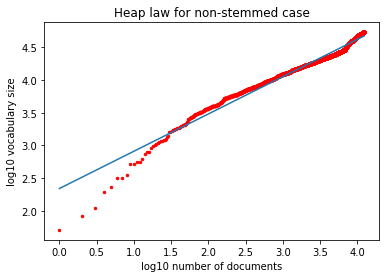

slope is  0.5702520931419564
intercept is  2.340710009415172
correlation coefficient is  0.9826703930393507
regression's p value is  0.0
expected dictionary size for full document set is  46881.96997790645
real dictionary size for full document set is  40405


In [ ]:
postingList = np.load('/content/drive/MyDrive/Information Retreival/savedPL.npy',allow_pickle='TRUE').item()
print()
plt.scatter(x, y,s=6,color='red')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.title("Heap law for non-stemmed case")
plt.xlabel("log10 number of documents")
plt.ylabel("log10 vocabulary size")
plt.show()

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

print("slope is ",slope)
print("intercept is ",intercept)
print("correlation coefficient is ",r_value)
print("regression's p value is ",p_value)
print("expected dictionary size for full document set is ",10**(slope*np.log10(data.shape[1])+intercept))
print("real dictionary size for full document set is ",len(postingList))

**Stemming issues**

In [ ]:
print(stemmer.stem('زیان'))
print(stemmer.stem('کتب'),stemmer.stem('کتاب‌ها'))
print(stemmer.stem('اسکان'),stemmer.stem('تعلم'))

ر
کتب کتاب
اسک اسک
